In [209]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]+['eval','cleaned','']))
from params_opt_maps import *

In [5]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'
path_tab=path_data+'tables/'

In [150]:
# Names
model_map={**pkl.load(open(path_names+'models.pkl','rb')),
           **pkl.load(open(path_names+'models_additional.pkl','rb'))}
model_map_rev=dict(zip(model_map.values(),model_map.keys()))
param_map=pkl.load(open(path_names+'params.pkl','rb'))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))
cell_type_map=pkl.load(open(path_names+'cell_types.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

## Location of gamma/delta/alpha cells of both species in individual models

In [90]:
# Load embeddings
embeds_umap={}
dataset='pancreas_conditions_MIA_HPAP2'
dataset_name=dataset_map[dataset]
top_settings=pkl.load(open(f'{path_data}eval/{dataset}/integration_summary/top_settings.pkl','rb'))
path_integration=f'{path_data}eval/{dataset}/integration/'
for model,model_setting in top_settings.items():
    model=model_map[model]
    for run in model_setting['runs']:
        if run==model_setting['mid_run']:
            embeds_umap[model]=sc.read(path_integration+run+'/embed.h5ad')

# Non-integrated embeddings - based on per system PCA
embeds_umap[model_map['non-integrated']]=sc.read(
    f'{path_data}{dataset}/combined_orthologuesHVG_embed.h5ad')

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: N

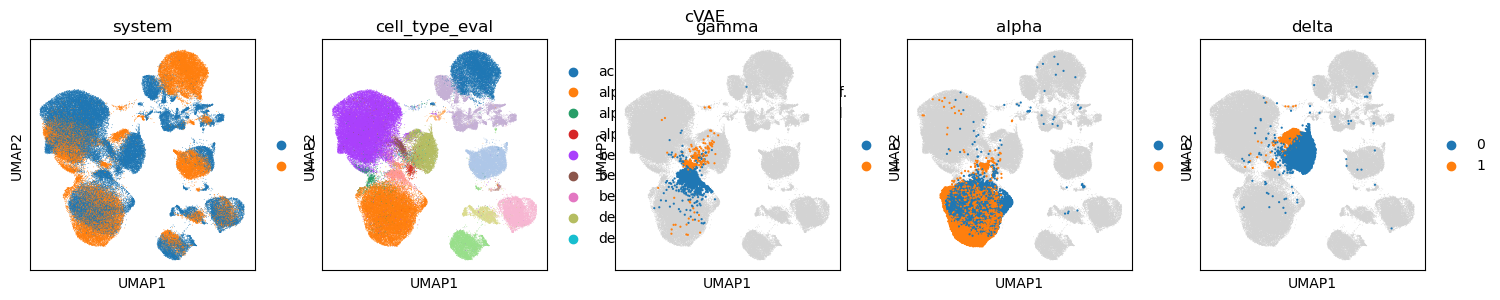

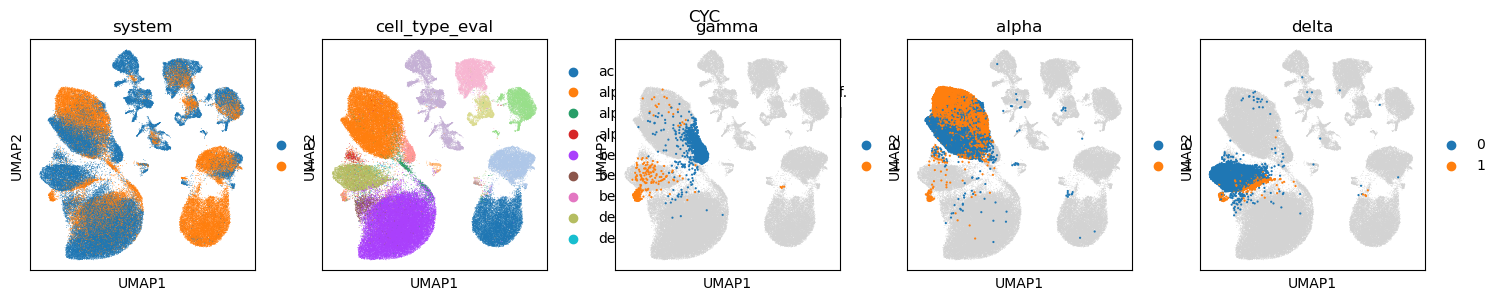

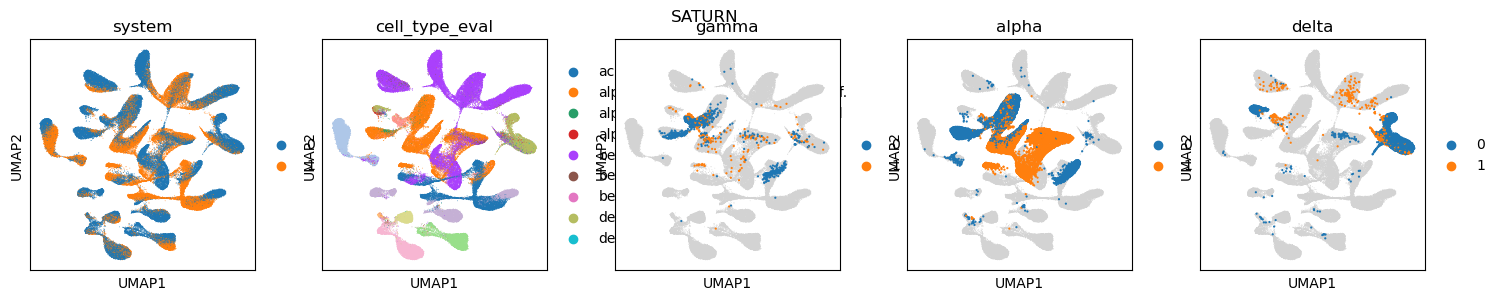

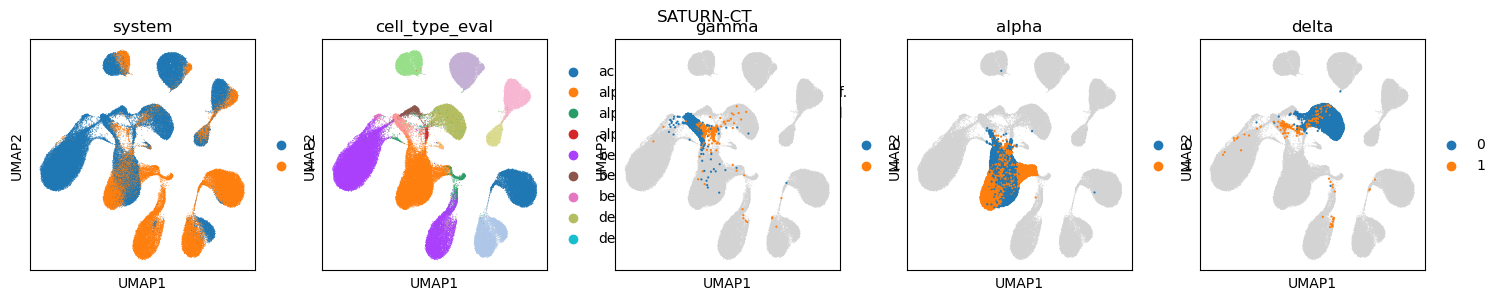

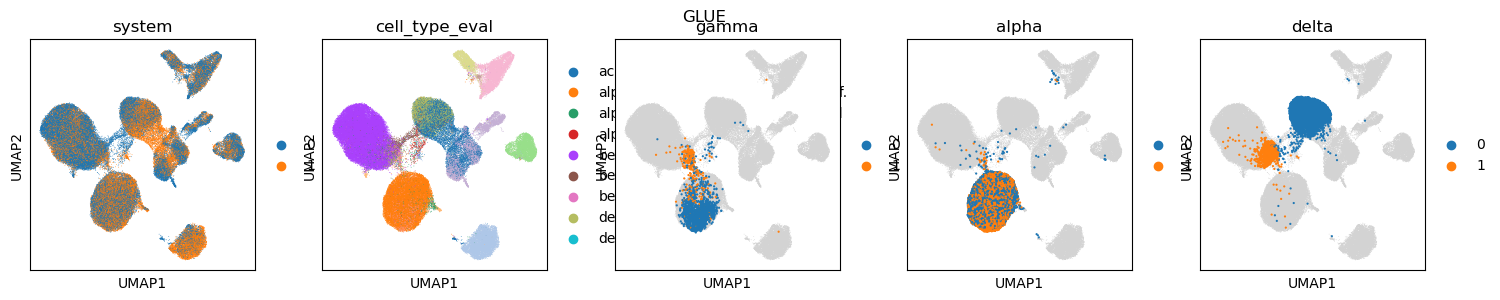

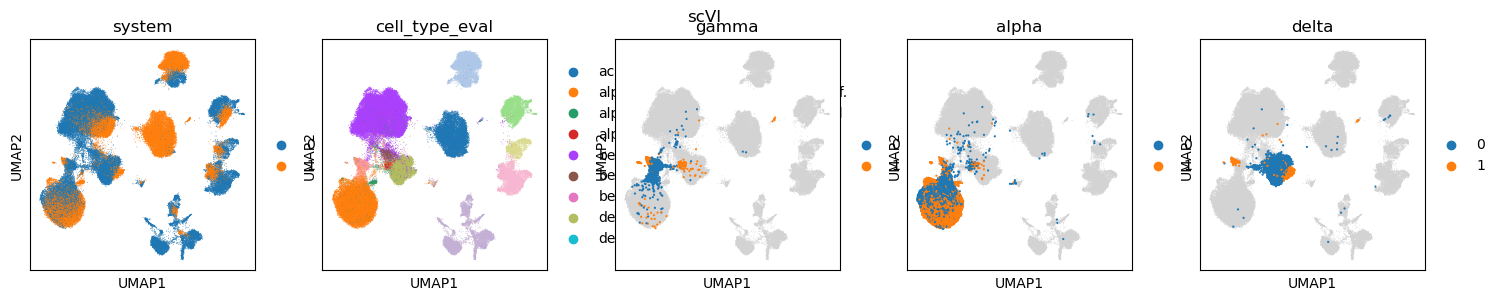

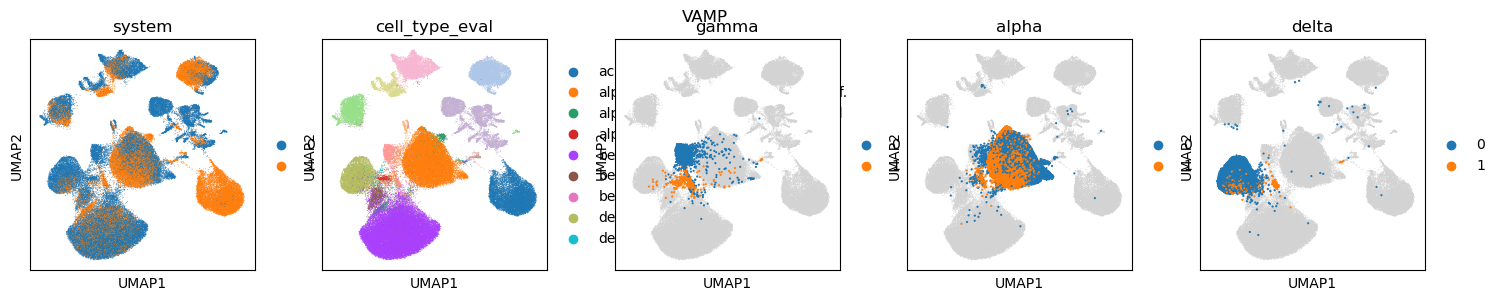

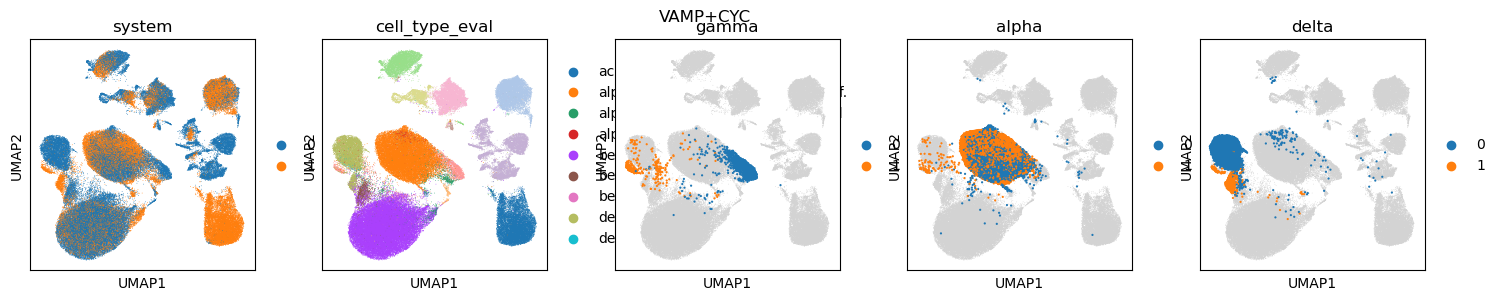

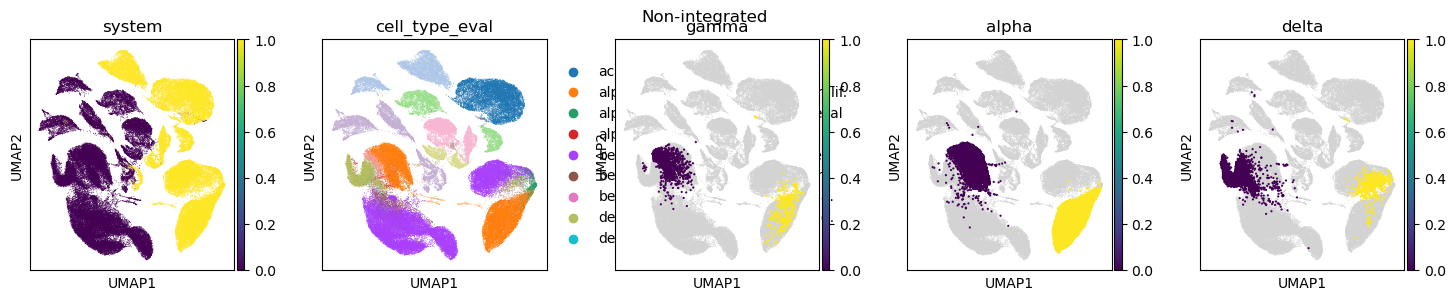

In [183]:
# Plot location of gamma cells in individual systems per model
for model,embed in embeds_umap.items():
    fig,ax=plt.subplots(1,5,figsize=(18,3))
    fig.suptitle(model)    
    sc.pl.umap(embed,color='system',ax=ax[0],show=False)
    sc.pl.umap(embed,color='cell_type_eval',ax=ax[1],show=False)
    for i,ct in enumerate(['gamma','alpha','delta']):
        i=i+2
        sc.pl.umap(embed,ax=ax[i],show=False)
        sc.pl.umap(embed[embed.obs.cell_type_eval==ct,:],color='system',ax=ax[i],
                   show=False,s=10,title=ct)
    plt.subplots_adjust(wspace=0.3)

## Distance of gamma cells to delta and alpha cells in both systems

In [46]:
# Load full embeddings
embeds={}
dataset='pancreas_conditions_MIA_HPAP2'
dataset_name=dataset_map[dataset]
top_settings=pkl.load(open(f'{path_data}eval/{dataset}/integration_summary/top_settings.pkl','rb'))
path_integration=f'{path_data}eval/{dataset}/integration/'
for model,model_setting in top_settings.items():
    model=model_map[model]
    for run in model_setting['runs']:
        if run==model_setting['mid_run']:
            embeds[model]=sc.read(path_integration+run+'/embed_full.h5ad')

# Non-integrated embeddings - based on per system PCA
adata_temp=sc.read( f'{path_data}{dataset}/combined_orthologuesHVG.h5ad')
embeds[model_map['non-integrated']]=sc.AnnData(adata_temp.obsm['X_pca_system'],obs=adata_temp.obs)
del adata_temp

In [72]:
# Filter samples with enough cells in every of the relevant celltypes
embed_ni=embeds[model_map['non-integrated']]
cts=['alpha','delta','gamma']
obs_sub=embed_ni.obs.query('cell_type_eval in @cts')
counts=pd.crosstab(obs_sub['batch'],obs_sub['cell_type_eval'])
keep=(counts>=5).all(axis=1).rename('keep').to_frame()
keep['system']=keep.index.map(dict(zip(embed_ni.obs.batch,embed_ni.obs.system))
                             ).astype(str).map(system_map[dataset])
print("All samples per system:",keep.system.value_counts(sort=False).to_dict())
print('Kept samples per system:',keep[keep.keep].system.value_counts(sort=False).to_dict())

All samples per system: {'Mouse': 52, 'Human': 65}
Kept samples per system: {'Mouse': 49, 'Human': 54}


### Alpha/delta KNNs to gamma cells
Find how many KNNs of gamma cells come from alpha/delta cells. 

As the adata is large the KNNs are computed only on alpha, delta, and gamma cells together.

In [ ]:
# Subset to relevant cts
embeds_sub={model:embed[embed.obs.cell_type_eval.isin(cts),:].copy() for model,embed in embeds.items()}
# non-integrated should not be checked as there PCA is computed per system
del embeds_sub[model_map['non-integrated']]
# Add non-integrated per-system embeds
embed=embeds[model_map['non-integrated']]
for system, system_name in system_map[dataset].items()
    embeds_sub[model_map['non-integrated'] +' '+ system_name]=embed[
        embed.obs.cell_type_eval.isin(cts).values & 
        (embed.obs.system.astype(str)==system).values,:].copy() 

In [ ]:
# Compute KNNs for relevant cts
for model,embed in embeds_sub.items():
    print(model)
    sc.pp.neighbors(embed, use_rep='X', n_neighbors=90) 

In [219]:
knns=[]
for model_name,embed in embeds_sub.items():
    alpha_s0_idx=set(np.argwhere(
        (embed.obs.cell_type_eval=="alpha").values &
        (embed.obs.system.astype(str)=='0').values
    ).ravel())    
    alpha_s1_idx=set(np.argwhere(
        (embed.obs.cell_type_eval=="alpha").values &
        (embed.obs.system.astype(str)=='1').values
    ).ravel())
    delta_s0_idx=set(np.argwhere(
        (embed.obs.cell_type_eval=="delta").values &
        (embed.obs.system.astype(str)=='0').values
    ).ravel())    
    delta_s1_idx=set(np.argwhere(
        (embed.obs.cell_type_eval=="delta").values &
        (embed.obs.system.astype(str)=='1').values
    ).ravel())
    gamma_bool=(embed.obs.cell_type_eval=="gamma").values
    for batch,system in keep[keep.keep]['system'].iteritems():
        gamma_idx=np.argwhere(
            (embed.obs.batch==batch).values & gamma_bool
        ).ravel()
        n_gamma=len(gamma_idx)
        if n_gamma>0:
            neigh=embed.obsp['connectivities'][gamma_idx,].nonzero()
            knn_alpha_s0=len([i for i in neigh[1] if i in alpha_s0_idx])/n_gamma
            knn_alpha_s1=len([i for i in neigh[1] if i in alpha_s1_idx])/n_gamma
            knn_delta_s0=len([i for i in neigh[1] if i in delta_s0_idx])/n_gamma
            knn_delta_s1=len([i for i in neigh[1] if i in delta_s1_idx])/n_gamma
            knns.append(dict(
                batch=batch,system=system,model=model_name,
                alpha_s0=knn_alpha_s0,alpha_s1=knn_alpha_s1,
                delta_s0=knn_delta_s0,delta_s1=knn_delta_s1,
            ))
knns=pd.DataFrame(knns)
# Rename the nonintegrated to be one category again
knns['model']=knns['model'].apply(
    lambda x: model_map['non-integrated'] if x.startswith(model_map['non-integrated']) else x)

/tmp/ipykernel_11984/2425205356.py:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for batch,system in keep[keep.keep]['system'].iteritems():


In [230]:
knns_plot=[]
for ct in ['alpha_s0','alpha_s1','delta_s0','delta_s1']:
    knns_sub=knns[['batch','system','model',ct]].copy()
    knns_sub.rename({ct:'knns'},axis=1,inplace=True)
    knns_sub['ct']=ct
    knns_plot.append(knns_sub)
knns_plot=pd.concat(knns_plot)

Plot showing for mouse and human gamma cells (colored) how many KNNs (y axis) have populations of alpha and delata cels per species (x axis).

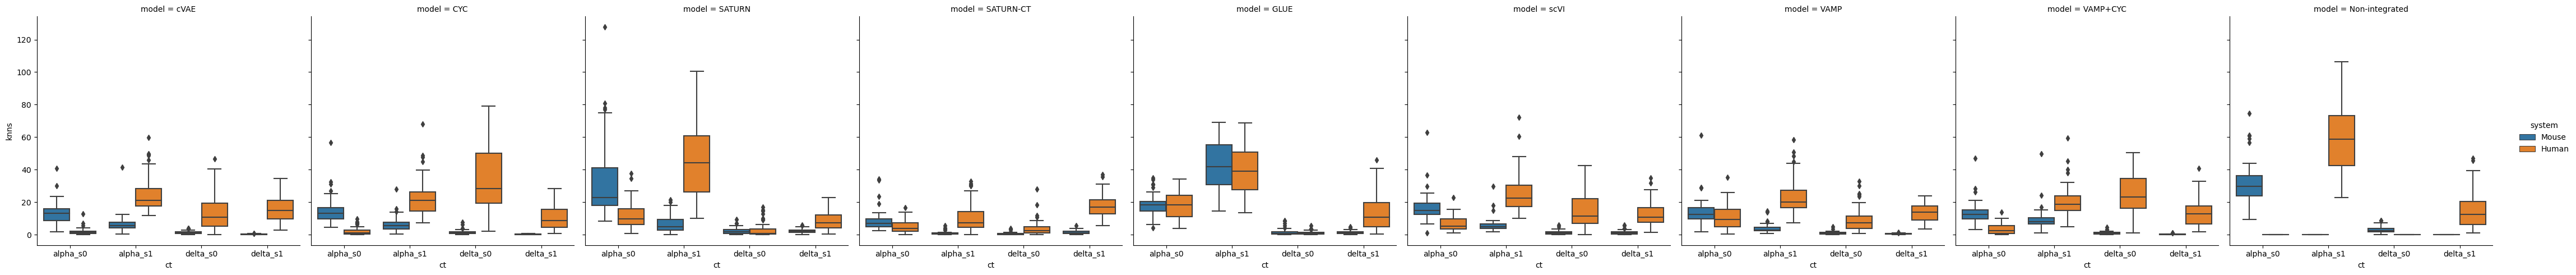

In [232]:
sb.catplot(col='model',y='knns',hue='system',x='ct',data=knns_plot,kind='box')

C: It seems like human gamma cells may be closer to mouse delta cells than human delta cells. - That may be the reason taht we dont observe such strong closeness when doing analysis per species on non-integrated data. 

C: Also, as seen above and on cellxgene of the human dataset the human gamma cells are unclean, contaminated by doublets of alpha-delta and ghrl cells.

C: This does not account for overall N of alpha/delta/gamma cells, but it may not matter that much as it is only done locally.

C: Maybe we dont see the effect of mouse delta cells being close to human gama in non-cyc models as they are not integrated that well?

C: on the above UMAPs it is quite clear that in all models, even scVI and cVAE there is a population of human gamma cells (maybe the clean one without doublets) that moves towards delta cells. And these delta cells that overlap are more from the mouse.

Significance of difference between distn of KNNs being alpha or delta cells, separately per species. TODO

### Distance between per sample and celltype embedding means - UNUSED
Note that this does not work well as the means are not representative of the whole cluster. Thus KNN analysis aproach is better.

In [99]:
# Per sample distance between gamma and alpha or delta cells 
# and ratio of distance to alpha vs delta cells
dists=[]
for batch,system in keep[keep.keep]['system'].iteritems():
    obs=embed_ni.obs.query('batch ==@batch')
    cells={}
    for ct in cts:
        cells[ct]=obs.query('cell_type_eval==@ct').index
    for model_name,embed in embeds.items():
        means={}
        for ct in cts:
            means[ct]=embed[cells[ct],:].X.mean(axis=0)
        dif_a_g=np.linalg.norm(means['alpha']-means['gamma'])
        dif_d_g=np.linalg.norm(means['delta']-means['gamma'])
        dists.append(dict(
            batch=batch, system=system,model=model_name,
            gamma_alpha=dif_a_g,gamma_delta=dif_d_g
        ))
dists=pd.DataFrame(dists)
dists['gamma_delta/gamma_alpha']=dists['gamma_delta']/dists['gamma_alpha']

/tmp/ipykernel_11984/2111635821.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for batch,system in keep[keep.keep]['system'].iteritems():


In [89]:
# Display distances per model and species (averaged across samples)
dists.groupby(['system','model'])[['gamma_delta/gamma_alpha']].mean().reset_index().pivot(columns='system',index='model')

gamma_delta/gamma_alpha          
system                           Human     Mouse
model                                           
CYC                           0.920955  1.258209
GLUE                          1.182047  2.794918
Non-integrated                1.323726  2.872416
SATURN                        1.849609  2.562358
SATURN-CT                     0.845937  1.136115
VAMP                          0.927168  1.406947
VAMP+CYC                      0.964734  1.266832
cVAE                          0.960413  0.975619
scVI                          0.882228  1.142770